<a href="https://colab.research.google.com/github/UN-GCPDS/Unemployment-Rate-Prediction/blob/main/Supervised_Approach_Generate_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Funciones y librerías

In [1]:
# ========================================
# 1. Instalación de librerías externas
# ========================================
#!pip install pmdarima==1.8.5
!pip install -q -U keras-tuner

# ========================================
# 2. Librerías base y utilidades generales
# ========================================
import warnings
import numpy as np
import pandas as pd
from tabulate import tabulate

# ========================================
# 3. Visualización
# ========================================
import matplotlib.pyplot as plt
import seaborn as sns

# ========================================
# 4. Preprocesamiento de datos
# ========================================
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

# ========================================
# 5. Modelos de regresión clásicos
# ========================================
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge

# ========================================
# 6. Modelos bayesianos y de procesos gaussianos
# ========================================
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern, ExpSineSquared, DotProduct

# ========================================
# 7. Modelos estadísticos y series temporales
# ========================================
#import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# ========================================
# 8. Evaluación de modelos
# ========================================
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# ========================================
# 9. Keras Tuner para ajuste de hiperparámetros
# ========================================
from keras_tuner import BayesianOptimization as OriginalBayesianOptimization
from keras_tuner.oracles import BayesianOptimizationOracle as OriginalBayesianOptimizationOracle
from keras_tuner import Tuner, Objective
from keras_tuner.tuners import SklearnTuner
from keras_tuner.src.engine import hyperparameters as hp_module
from keras_tuner.src.engine import oracle as oracle_module
from keras_tuner.src.engine import trial as trial_module
from keras_tuner.src.engine import tuner as tuner_module
from keras_tuner.src.api_export import keras_tuner_export

# ========================================
# 10. Configuración de warnings
# ========================================
warnings.filterwarnings("ignore", category=UserWarning, message="Non-stationary starting autoregressive parameters found")
warnings.filterwarnings("ignore", category=UserWarning, message="Non-invertible starting MA parameters found")
warnings.filterwarnings("ignore", category=ConvergenceWarning, message="Maximum Likelihood optimization failed to converge")
warnings.filterwarnings(
    "ignore",
    category=ConvergenceWarning,
    message="The optimal value found for dimension.*parameter length_scale.*"
)
!git clone https://github.com/UN-GCPDS/Unemployment-Rate-Prediction.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00
Cloning into 'Unemployment-Rate-Prediction'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 117 (delta 35), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 2.10 MiB | 6.92 MiB/s, done.
Resolving deltas: 100% (35/35), done.


#Data

In [2]:
FILEID ="1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O datos.xlsx && rm -rf /tmp/cookies.txt
!dir

import pandas as pd
Xdata = pd.read_excel('datos.xlsx')
Xdata.head()
Xdata.fillna(Xdata.mean(), inplace=True)
Xdata.describe()



Xdata=Xdata[['Año', 'Mes', 'TGP',  'salarios reales', 'Indicador de Seguimiento a la Economía',
       'imporenta real', 'iva real',
       'Tasa de intervención de política monetaria (%)','TD']]#'TD-1','TD-2','TD-3' ,'TD']]
Xdata.rename(columns={'Año': 'Year', 'Mes':'Month', 'TGP':'GPR',
       'salarios reales':'RS', 'Indicador de Seguimiento a la Economía':'EMI',
       'imporenta real':'RIT', 'iva real':'RVT',
       'Tasa de intervención de política monetaria (%)':'MPIR','TD':'UR'},inplace=True) #'TD-1':'UR-1','TD-2':'UR-2','TD-3':'UR-3','TD':'UR'}, inplace=True)


X_new=Xdata.loc[1:,['GPR','RS','EMI','RIT','RVT','MPIR','UR']]#,
Xdata=Xdata.iloc[:-1]
Xdata[['GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1','UR-1']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',

#Xdata=pd.DataFrame(scaler.fit_transform(Xdata),columns=Xdata.columns)
X_new=Xdata.loc[1:,['GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1','UR-1']]#'GPR','RS','EMI','RIT','RVT','MPIR',
Xdata=Xdata.iloc[:-1]
Xdata[['GPR-2','RS-2','EMI-2','RIT-2','RVT-2','MPIR-2','UR-2']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',

#Xdata=pd.DataFrame(scaler.fit_transform(Xdata),columns=Xdata.columns)
X_new=Xdata.loc[1:,['GPR-2','RS-2','EMI-2','RIT-2','RVT-2','MPIR-2','UR-2']]#'GPR','RS','EMI','RIT','RVT','MPIR',
Xdata=Xdata.iloc[:-1]
Xdata[['GPR-3','RS-3','EMI-3','RIT-3','RVT-3','MPIR-3','UR-3']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',

#Xdata=pd.DataFrame(scaler.fit_transform(Xdata),columns=Xdata.columns)
X_new=Xdata.loc[1:,['GPR-3','RS-3','EMI-3','RIT-3','RVT-3','MPIR-3','UR-3']]#'GPR','RS','EMI','RIT','RVT','MPIR',
Xdata=Xdata.iloc[:-1]
Xdata[['GPR-4','RS-4','EMI-4','RIT-4','RVT-4','MPIR-4','UR-4']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',
#Xdata=pd.DataFrame(scaler.fit_transform(Xdata),columns=Xdata.columns)
X_new=Xdata.loc[1:,['GPR-4','RS-4','EMI-4','RIT-4','RVT-4','MPIR-4','UR-4']]#'GPR','RS','EMI','RIT','RVT','MPIR',
Xdata=Xdata.iloc[:-1]
Xdata[['GPR-5','RS-5','EMI-5','RIT-5','RVT-5','MPIR-5','UR-5']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',
# X_new=Xdata.loc[1:,'TD-1']
# Xdata=Xdata.iloc[:-1]
# Xdata['TD-2']=X_new.values
# X_new=Xdata.loc[1:,'TD-2']
# Xdata=Xdata.iloc[:-1]
# Xdata['TD-3']=X_new.values
print(Xdata.info())
scaler= MinMaxScaler()
Xdata.iloc[:,2:]=scaler.fit_transform(Xdata.iloc[:,2:])
X=Xdata.drop(['UR-5','Year','Month'], axis=1).values
y=Xdata['UR-5'].values

Xdata
i=['KRRBF','KNN','GP','Linear','Lasso','Elastic','SGD','BayesRid','RF','SVR']
Xdata

--2025-04-02 04:08:16--  https://docs.google.com/uc?export=download&confirm=&id=1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd
Resolving docs.google.com (docs.google.com)... 173.194.217.139, 173.194.217.100, 173.194.217.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd&export=download [following]
--2025-04-02 04:08:16--  https://drive.usercontent.google.com/download?id=1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.11.132, 2607:f8b0:400c:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.11.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25514 (25K) [application/octet-stream]
Saving to: ‘datos.xlsx’

datos.xlsx          100%[===================>]  24.92K  --.-KB/

<ipython-input-2-aa1bc6039fb8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata[['GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1','UR-1']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',
<ipython-input-2-aa1bc6039fb8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xdata[['GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1','UR-1']]=X_new.values#'GPR-1','RS-1','EMI-1','RIT-1','RVT-1','MPIR-1',
<ipython-input-2-aa1bc6039fb8>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy 

,Year,Month,GPR,RS,EMI,RIT,RVT,MPIR,UR,GPR-1,...,RVT-4,MPIR-4,UR-4,GPR-5,RS-5,EMI-5,RIT-5,RVT-5,MPIR-5,UR-5
0,2005,1,0.566685,0.056592,0.007883,0.126715,0.301695,0.413043,0.421572,0.559883,...,0.241469,0.413043,0.356861,0.499942,0.012690,0.004395,0.310485,0.012233,0.413043,0.301422
1,2005,2,0.559883,0.041833,0.000000,0.184955,0.000000,0.413043,0.493229,0.539690,...,0.012233,0.413043,0.301422,0.636869,0.011952,0.001314,0.096573,0.259959,0.413043,0.334936
2,2005,3,0.539690,0.030640,0.012944,0.080370,0.248774,0.413043,0.402437,0.547940,...,0.259959,0.413043,0.334936,0.550504,0.011952,0.037731,0.259239,0.018832,0.413043,0.317803
3,2005,4,0.547940,0.024107,0.040339,0.377872,0.005906,0.413043,0.339548,0.559787,...,0.018832,0.413043,0.317803,0.571000,0.005829,0.056272,0.120651,0.285131,0.369565,0.276504
4,2005,5,0.559787,0.018376,0.040350,0.128403,0.242314,0.413043,0.356861,0.499942,...,0.285131,0.369565,0.276504,0.645324,0.002423,0.092763,0.170315,0.004714,0.369565,0.190256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2023,3,0.834814,1.000000,0.849983,0.269587,0.157152,0.956522,0.193445,0.848108,...,0.141804,1.000000,0.158003,0.841461,1.000000,0.842506,0.239263,0.138201,1.000000,0.150914
219,2023,4,0.848108,1.000000,0.745439,0.263522,0.153554,0.956522,0.235975,0.808226,...,0.138201,1.000000,0.150914,0.828167,1.000000,0.808033,0.233199,0.134599,1.000000,0.172180
220,2023,5,0.808226,1.000000,0.809333,0.257457,0.149956,0.978261,0.214710,0.841461,...,0.134599,1.000000,0.172180,0.781639,1.000000,0.800305,0.227134,0.130997,1.000000,0.193445
221,2023,6,0.841461,1.000000,0.827962,0.251393,0.146358,1.000000,0.172180,0.861402,...,0.130997,1.000000,0.193445,0.808226,1.000000,0.889100,0.221069,0.127395,1.000000,0.207622


#Plots

In [3]:
# Asegúrate de eliminar cualquier instancia previa de grid_search o modelos
try:
    del grid_search  # Borra el objeto grid_search si existe
    del model  # Borra el modelo si existe
except NameError:
    pass  # Si no existen, continua sin errores

# Asumiendo que tienes X, y definidos
# División de los datos sin barajar y con un 10% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Definición del modelo con los hiperparámetros proporcionados
model = GaussianProcessRegressor(
    alpha=1,  # El valor inicial, puede ser modificado por GridSearchCV
    kernel=RBF(length_scale=np.ones(X.shape[1]), length_scale_bounds=(1, 1000000)),  # Kernel RBF con límites de longitud de escala
    normalize_y=True,
    random_state=42
)

# Definición del espacio de hiperparámetros a buscar
param_grid = {
    'alpha': [1e-5, 1e-3, 1e-1, 1, 10, 1e2] # Buscando en el rango de bounds del length_scale
}

# Definición de las métricas a evaluar
scoring = {
    'R2': make_scorer(r2_score),
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False)  # Invertido para que la MAE menor sea mejor
}

# Función para ejecutar GridSearchCV con diferentes folds y recopilar métricas
def run_grid_search(cv_folds):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_folds,
        n_jobs=-1,
        scoring=scoring,
        refit='R2',  # Refit usando R2 como métrica principal
        return_train_score=True
    )
    grid_search.fit(X_train, y_train)
    fold_r2_scores = [grid_search.cv_results_[f'split{i}_test_R2'][grid_search.best_index_] for i in range(cv_folds)]
    fold_mae_scores = [-grid_search.cv_results_[f'split{i}_test_MAE'][grid_search.best_index_] for i in range(cv_folds)]
    return fold_r2_scores, fold_mae_scores

# Ejecutar GridSearch con 5 folds y 10 folds
r2_scores_5, mae_scores_5 = run_grid_search(5)
r2_scores_10, mae_scores_10 = run_grid_search(10)



/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 8 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 15 of parameter length_scale is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value f

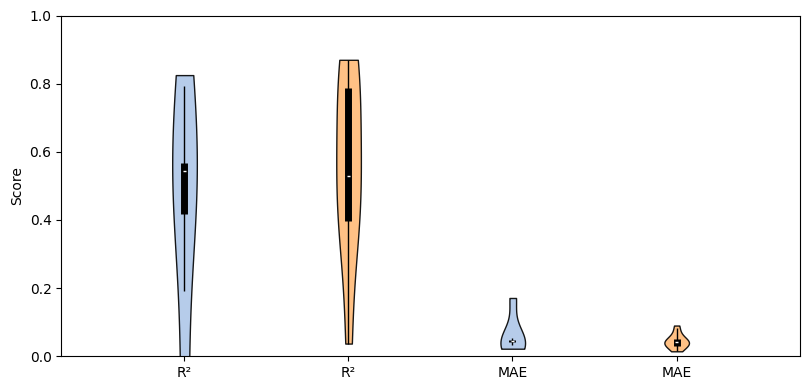

In [4]:
import matplotlib.pyplot as plt
import numpy as np
data = [
    np.sort(r2_scores_5),
    np.sort(r2_scores_10),
    np.sort(mae_scores_5),
    np.sort(mae_scores_10)
]

labels = ['R²', 'R²', 'MAE', 'MAE']

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_ylim(0, 1)

fig, ax = plt.subplots(figsize=(8, 4))

parts = ax.violinplot(
    data, showmeans=False, showmedians=False, showextrema=False
)

# Tonos pastel: azul para R², naranja para MAE
violin_colors = ['#aec7e8','#ffbb78','#aec7e8', '#ffbb78']  # tonos pastel

scale_factor = 0.3  # Violines delgados para evitar sobresalir

for i, (pc, color) in enumerate(zip(parts['bodies'], violin_colors)):
    pc.set_facecolor(color)
    pc.set_edgecolor('black')
    pc.set_alpha(0.9)

    # Escalar el ancho del violín
    verts = pc.get_paths()[0].vertices
    x = verts[:, 0]
    x_mean = np.mean(x)
    verts[:, 0] = (x - x_mean) * scale_factor + x_mean

# Calcular cuartiles y bigotes
quartile1, medians, quartile3 = [], [], []

for d in data:
    q1, med, q3 = np.percentile(d, [25, 50, 75])
    quartile1.append(q1)
    medians.append(med)
    quartile3.append(q3)

quartile1 = np.array(quartile1)
medians = np.array(medians)
quartile3 = np.array(quartile3)

whiskers = np.array([
    adjacent_values(d, q1, q3) for d, q1, q3 in zip(data, quartile1, quartile3)
])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

# Posiciones X
inds = np.arange(1, len(data) + 1)

# Dibujar elementos de boxplot
# Dibujar una línea horizontal en la mediana
for i, med in enumerate(medians, start=1):
    ax.hlines(med, i - 0.01, i + 0.01, color='white', linewidth=1, zorder=10)

ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Estilo de ejes y título
set_axis_style(ax, labels)
plt.tight_layout()
plt.ylabel('Score')
plt.savefig('CV5-10.pdf')
plt.show()


In [5]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae =mean_absolute_error(y_test, y_pred)
    return mse,rmse,mape,r2,mae
# Definición de columnas y etiquetas
columnas = ['Model','MSE0', 'MSE1', 'RMSE0', 'RMSE1', 'MAPE0', 'MAPE1', 'MAE0', 'MAE1', 'R20', 'R21']
labels = ['ARIMA', 'SARIMA', 'RF', 'Lasso', 'SVR', 'Elastic', 'GP']
# Crear el DataFrame vacío
df = pd.DataFrame(columns=columnas)
# Lista para almacenar las filas
filas = []
path='/content/Unemployment-Rate-Prediction/'
# Bucle para procesar cada modelo
for label in labels:
    # Cargar datos
    data0 = pd.read_excel(f'{path}3 Meses/Results/{label}_0.xlsx')
    data1 = pd.read_excel(f'{path}3 Meses/Results/{label}_1.xlsx')
    # Extraer valores
    y_test = data0['y_true'].values
    y_pred0 = data0['y_pred'].values
    y_pred1 = data1['y_pred'].values
    # Calcular métricas
    mse0, rmse0, mape0, r20, mae0 = evaluate_model(y_test, y_pred0)
    mse1, rmse1, mape1, r21, mae1 = evaluate_model(y_test, y_pred1)
    # Crear nueva fila
    nueva_fila = pd.Series([label,mse0, mse1, rmse0, rmse1, mape0, mape1, mae0, mae1, r20, r21], index=columnas)
    # Agregar la nueva fila a la lista de filas
    filas.append(nueva_fila)
# Concatenar todas las filas en un único DataFrame
df = pd.concat(filas, axis=1).T.reset_index(drop=True)
# Mostrar el DataFrame resultante
df

,Model,MSE0,MSE1,RMSE0,RMSE1,MAPE0,MAPE1,MAE0,MAE1,R20,R21
0,ARIMA,0.012558,0.011073,0.012558,0.011073,2678342081261.073242,2475106255790.622559,0.072566,0.068178,0.459243,0.523171
1,SARIMA,0.012888,0.017979,0.012888,0.017979,1146158407963.081055,2395771223938.307617,0.071973,0.098295,0.445043,0.225818
2,RF,0.010371,0.010366,0.010371,0.010366,1427641783565.793457,2067789553016.4729,0.062629,0.064514,0.553422,0.553614
3,Lasso,0.007324,0.010322,0.007324,0.010322,1627353532108.505859,2320194430442.037109,0.057754,0.064364,0.68463,0.555532
4,SVR,0.006832,0.010931,0.006832,0.010931,1149319514493.565186,2199473561720.596191,0.053889,0.066094,0.70582,0.529299
5,Elastic,0.022066,0.011864,0.022066,0.011864,5209706216688.442383,2320194430442.077148,0.103309,0.071205,0.049842,0.48913
6,GP,0.0047,0.009919,0.0047,0.009919,705934321795.105103,1645697662856.427979,0.047853,0.062204,0.797612,0.572863


In [6]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae =mean_absolute_error(y_test, y_pred)
    return mse,rmse,mape,r2,mae
# Definición de columnas y etiquetas
columnas = ['Model','MSE0', 'MSE1', 'RMSE0', 'RMSE1', 'MAPE0', 'MAPE1', 'MAE0', 'MAE1', 'R20', 'R21']
labels = ['ARIMA', 'SARIMA', 'RF', 'Lasso', 'SVR', 'Elastic', 'GP']

# Crear el DataFrame vacío
df = pd.DataFrame(columns=columnas)

# Lista para almacenar las filas
filas = []

# Bucle para procesar cada modelo
for label in labels:
    # Cargar datos
    data0 = pd.read_excel(f'{path}12 Meses/Results/{label}_0.xlsx')
    data1 = pd.read_excel(f'{path}12 Meses/Results/{label}_1.xlsx')

    # Extraer valores
    y_test = data0['y_true'].values
    y_pred0 = data0['y_pred'].values
    y_pred1 = data1['y_pred'].values

    # Calcular métricas
    mse0, rmse0, mape0, r20, mae0 = evaluate_model(y_test, y_pred0)
    mse1, rmse1, mape1, r21, mae1 = evaluate_model(y_test, y_pred1)
    # Crear nueva fila
    nueva_fila = pd.Series([label,mse0, mse1, rmse0, rmse1, mape0, mape1, mae0, mae1, r20, r21], index=columnas)

    # Agregar la nueva fila a la lista de filas
    filas.append(nueva_fila)

# Concatenar todas las filas en un único DataFrame
df = pd.concat(filas, axis=1).T.reset_index(drop=True)
# Mostrar el DataFrame resultante
#df.to_excel('/content/drive/MyDrive/Doctorado/Optimización/Results.xlsx')
df

,Model,MSE0,MSE1,RMSE0,RMSE1,MAPE0,MAPE1,MAE0,MAE1,R20,R21
0,ARIMA,0.02172,0.020785,0.02172,0.020785,2553206780911.075684,3187602224285.674805,0.096305,0.094014,0.088399,0.127626
1,SARIMA,0.025623,0.020963,0.025623,0.020963,2767796413168.967285,1317725839276.691895,0.098581,0.091969,-0.075398,0.120185
2,RF,0.013919,0.016216,0.013919,0.016216,1139570041220.86792,2258022562724.75293,0.070985,0.077584,0.412142,0.315143
3,Lasso,0.010293,0.01781,0.010293,0.01781,1635625435205.055176,2841019552463.471191,0.066725,0.088294,0.56528,0.24784
4,SVR,0.009059,0.015408,0.009059,0.015408,90603734783.522308,2577806741817.149902,0.065834,0.079577,0.617403,0.349269
5,Elastic,0.024753,0.018441,0.024753,0.018441,5614584394450.915039,2841019552463.480957,0.109234,0.089868,-0.04539,0.221193
6,GP,0.007914,0.022305,0.007914,0.022305,458700824052.659302,1974201697168.808105,0.060461,0.093753,0.665776,0.057992


<ipython-input-7-9e61f8c2cd56>:13: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_data = Xdata.resample('Y').mean()
<ipython-input-7-9e61f8c2cd56>:48: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_data = data.resample('Y').agg({'Year': 'first', 'Month': 'first', 'UR-5': 'mean'})


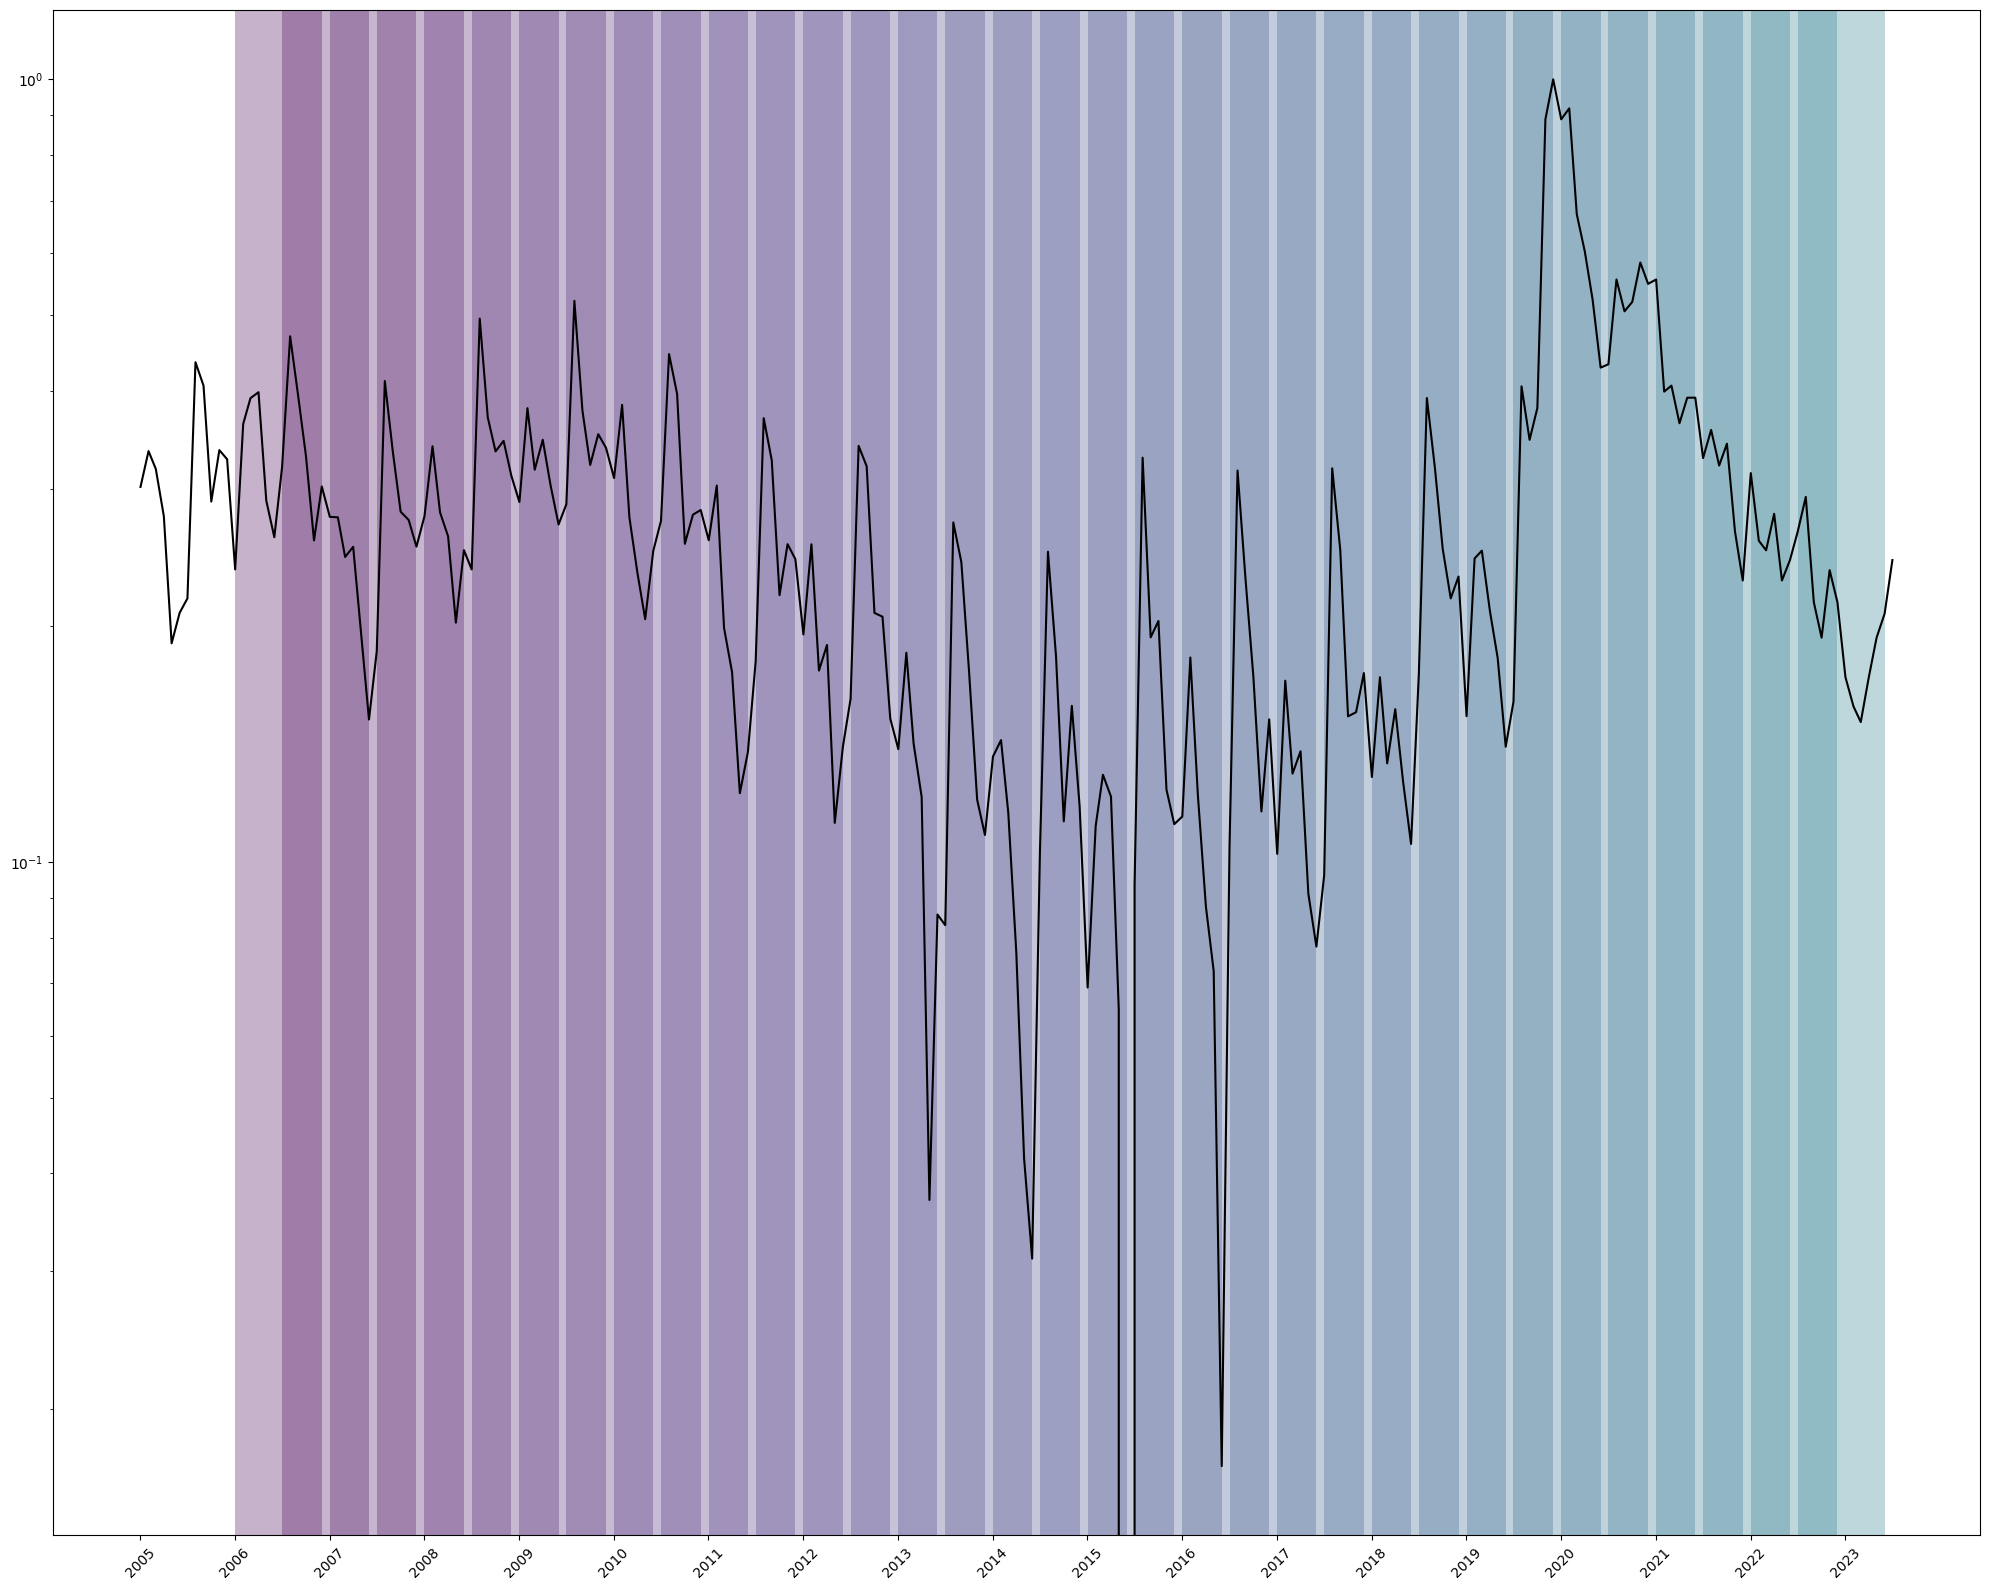

In [7]:
# Colores para los splits
# Colores para los splits
# Renombrar columnas para que sean compatibles con pd.to_datetime
#Xdata.rename(columns={'Año': 'year', 'Mes': 'month'}, inplace=True)

# Convertir 'year' y 'month' en un objeto de fecha y establecerlo como índice

Xdata['Fecha'] = pd.to_datetime(Xdata[['Year', 'Month']].assign(day=1))
Xdata = Xdata.set_index('Fecha')
# Añadir un punto para el año 2024
data_filtered = Xdata[(Xdata.index.month == 1) | (Xdata.index.month == 12)]
dates = data_filtered.index
annual_data = Xdata.resample('Y').mean()
years = annual_data.index
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
def obtener_indices_incrustados(tamano_total, tamano_ventana, cantidad_incrustada):
    indices = []

    # Recorremos las ventanas
    for i in range(0, tamano_total, tamano_ventana):
        indices.extend(range(i, min(i + cantidad_incrustada, tamano_total)))

    # Verificar si hay que completar con los últimos N índices
    tamano_actual = len(indices)
    tamano_deseado = (tamano_total // tamano_ventana) * cantidad_incrustada+cantidad_incrustada

    if tamano_actual < tamano_total:
        indices.extend(range(tamano_total - (tamano_deseado - tamano_actual), tamano_total))

    return indices


# Leer los datos de la base de datos
data = Xdata.copy()

# Renombrar columnas para que sean compatibles con pd.to_datetime
#data.rename(columns={'Año': 'year', 'Mes': 'month'}, inplace=True)

# Convertir 'year' y 'month' en un objeto de fecha y establecerlo como índice
data['Fecha'] = pd.to_datetime(data[['Year', 'Month']].assign(day=2))
data = data.set_index('Fecha')
annual_data = data.resample('Y').agg({'Year': 'first', 'Month': 'first', 'UR-5': 'mean'})
annual_data['Fecha'] = pd.to_datetime(annual_data[['Year', 'Month']].assign(day=1))
annual_data = annual_data.set_index('Fecha')

# Definir el número de splits y generar los splits una vez
n_splits = 70
tscv = TimeSeriesSplit(n_splits=n_splits)

# Asumiendo que y son tus datos de valor agrupados por año
y = data['UR'].values  # Reemplaza 'value' con el nombre de tu columna de datos
years = annual_data.index  # Obtener los años

# Colores para los splits
colors = plt.cm.viridis(np.linspace(0, 1, 80))

# Variables para almacenar las métricas
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []

# Descomposición estacional de la serie temporal
decomposition = seasonal_decompose(data['UR'], model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Crear las gráficas
fig, axs = plt.subplots(figsize=(20, 16))

# Gráfica 1: Valores medios por año y particiones usadas en test
axs.plot(data['UR-5'].index, data['UR-5'].values, color='black')
i = 0  # Inicializar el contador para los colores
i = 0  # Inicializar el contador para los colores
train_years = 1  # Años para entrenamiento
test_months = 12  # Meses para predicción
step_months = 6  # Meses para mover hacia adelante


for ind in range(12, data.shape[0] - test_months + 1, step_months):
    # Definir los intervalos de entrenamiento y prueba
    X_train, y_train = data.iloc[ind - train_years * 12:ind], y[ind - train_years * 12:ind]
    X_test, y_test = data.iloc[ind:ind + test_months], y[ind:ind + test_months]

    # Añadir la franja vertical para los períodos de test
    axs.axvspan(data.index[ind], data.index[ind + test_months - 1], facecolor=colors[i], alpha=0.3)

    i += 1  # Incrementar el índice del color

# Asegurar que los últimos 6 meses estén pintados si son el último set de predicción
axs.set_xticks(years)
axs.set_xticklabels(years.year, rotation=45)
axs.set_yscale('log')
plt.tight_layout()
pdf_path = 'Split.pdf'
plt.savefig(pdf_path)
plt.show()

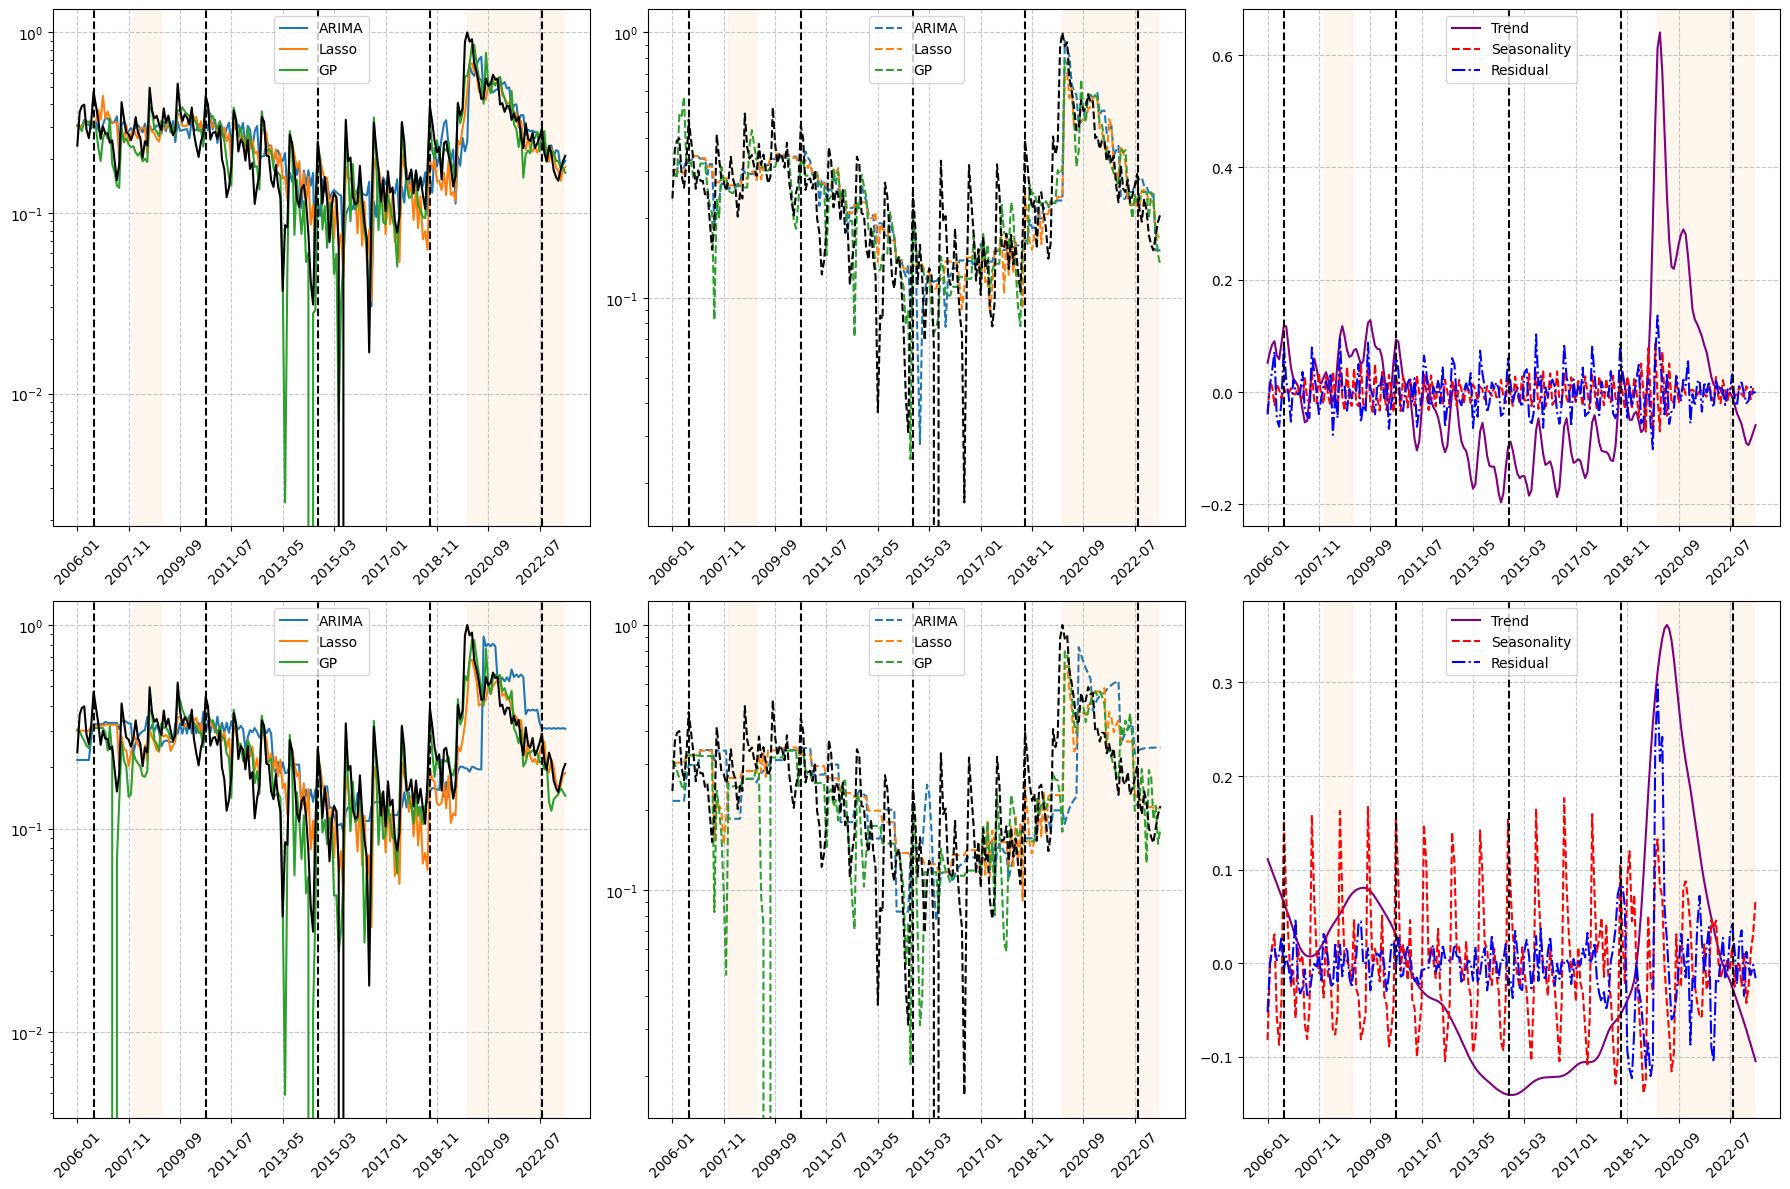

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
def obtener_indices_incrustados(tamano_total, tamano_ventana, cantidad_incrustada):
    indices = []

    # Recorremos las ventanas
    for i in range(0, tamano_total, tamano_ventana):
        indices.extend(range(i, min(i + cantidad_incrustada, tamano_total)))

    # Verificar si hay que completar con los últimos N índices
    tamano_actual = len(indices)
    tamano_deseado = (tamano_total // tamano_ventana) * cantidad_incrustada+cantidad_incrustada

    if tamano_actual < tamano_total:
        indices.extend(range(tamano_total - (tamano_deseado - tamano_actual), tamano_total))

    return indices
def plot_decomposition_and_models_combined(data, labels, highlight_periods, highlight_lines, params):
    """
    Genera una figura con 6 subplots organizados en 2 filas y 3 columnas:
    dos conjuntos de gráficas con predicciones de modelos y descomposición estacional.
    Para el modelo GP, se agrega una banda de confianza utilizando la columna y_std.

    :param data: DataFrame con los datos originales
    :param labels: Lista de listas con etiquetas de los modelos para los dos conjuntos
    :param highlight_periods: Lista de períodos a destacar con franjas
    :param highlight_lines: Lista de fechas a destacar con líneas verticales
    :param params: Lista de listas de parámetros para los dos conjuntos [periodo, cantidad_incrustada, fold]
    """

    # Crear una figura con 6 subplots en 2 filas y 3 columnas
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    def plot_individual_set(axes, row, data, labels1, labels2, highlight_periods, highlight_lines, params):
        periodo, cantidad_incrustada, fold = params
        tamano_total = len(data)
        tamano_ventana = periodo

        indices_resultantes = obtener_indices_incrustados(tamano_total, tamano_ventana, cantidad_incrustada)

        # Gráfica 1
        for label in labels1:
            data0 = pd.read_excel(f'{path}{fold}/Results/{label}_0.xlsx')
            y_pred0 = data0['y_pred'].values
            indices_resultantes = obtener_indices_incrustados(len(y_pred0), tamano_ventana, cantidad_incrustada)
            y_pred0 = y_pred0[indices_resultantes]
            if label == 'GP' and 'y_std' in data0.columns:
                y_std = data0['y_std'].values[indices_resultantes]
                lower_bound = y_pred0 - 1.96 * y_std
                upper_bound = y_pred0 + 1.96 * y_std
                #axes[row, 0].fill_between(data.index[12:-1], lower_bound, upper_bound, color='green', alpha=0.3, label=f'{label} 95% CI')

            axes[row, 0].plot(data.index[12:-1], y_pred0, label=label)

        axes[row, 0].plot(data.index[12:-1], data0['y_true'].values[indices_resultantes], color='black')

        # Ajuste del eje X para mostrar fechas completas
        axes[row, 0].set_xticks(data.index[12:-1][::int(len(data)/10)])  # Mostrar 10 fechas distribuidas en el eje X
        axes[row, 0].set_xticklabels(data.index.strftime('%Y-%m')[12:-1][::int(len(data)/10)], rotation=45)
        axes[row, 0].grid(True, linestyle='--', alpha=0.7)
        axes[row, 0].legend()
        axes[row, 0].set_yscale('log')

        for start, end in highlight_periods:
            axes[row, 0].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='bisque', alpha=0.3)

        for start, end in highlight_lines:
            axes[row, 0].axvline(pd.to_datetime(start), color='black', linestyle='--')

        # Gráfica 2
        for label in labels2:
            data0 = pd.read_excel(f'{path}{fold}/Results/{label}_1.xlsx')
            y_pred0 = data0['y_pred'].values
            indices_resultantes = obtener_indices_incrustados(len(y_pred0), tamano_ventana, cantidad_incrustada)
            y_pred0 = y_pred0[indices_resultantes]
            if label == 'GP' and 'y_std' in data0.columns:
                y_std = data0['y_std'].values[indices_resultantes]
                lower_bound = y_pred0 - 1.96 * y_std
                upper_bound = y_pred0 + 1.96 * y_std
                #axes[row, 1].fill_between(data.index[12:-1], lower_bound, upper_bound, color='green', alpha=0.3, label=f'{label} 95% CI')

            axes[row, 1].plot(data.index[12:-1], y_pred0, label=label, linestyle='--')

        axes[row, 1].plot(data.index[12:-1],data0['y_true'].values[indices_resultantes], color='black', linestyle='--')

        # Ajuste del eje X para mostrar fechas completas
        axes[row, 1].set_xticks(data.index[12:-1][::int(len(data)/10)])  # Mostrar 10 fechas distribuidas en el eje X
        axes[row, 1].set_xticklabels(data.index.strftime('%Y-%m')[12:-1][::int(len(data)/10)], rotation=45)
        axes[row, 1].grid(True, linestyle='--', alpha=0.7)
        axes[row, 1].legend()
        axes[row, 1].set_yscale('log')

        for start, end in highlight_periods:
            axes[row, 1].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='bisque', alpha=0.3)

        for start, end in highlight_lines:
            axes[row, 1].axvline(pd.to_datetime(start), color='black', linestyle='--')

        # Descomposición estacional
        stl = STL(data0['y_true'].values[indices_resultantes], period=periodo)
        result = stl.fit()

        seasonal = result.seasonal
        trend = result.trend - result.trend.mean()
        residual = result.resid

        axes[row, 2].plot(data.index[12:-1], trend, label='Trend', color='purple', linestyle='-')
        axes[row, 2].plot(data.index[12:-1], seasonal, label='Seasonality', color='red', linestyle='--')
        axes[row, 2].plot(data.index[12:-1], residual, label='Residual', color='blue', linestyle='-.')

        # Ajuste del eje X para mostrar fechas completas
        axes[row, 2].set_xticks(data.index[12:-1][::int(len(data)/10)])  # Mostrar 10 fechas distribuidas en el eje X
        axes[row, 2].set_xticklabels(data.index[12:-1].strftime('%Y-%m')[::int(len(data)/10)], rotation=45)
        axes[row, 2].grid(True, linestyle='--', alpha=0.7)
        axes[row, 2].legend()

        for start, end in highlight_periods:
            axes[row, 2].axvspan(pd.to_datetime(start), pd.to_datetime(end), color='bisque', alpha=0.3)

        for start, end in highlight_lines:
            axes[row, 2].axvline(pd.to_datetime(start), color='black', linestyle='--')

    # Plotea el primer conjunto de gráficas en la primera fila
    plot_individual_set(axes, 0, data, labels[0], labels[1], highlight_periods, highlight_lines, params[0])

    # Plotea el segundo conjunto de gráficas en la segunda fila
    plot_individual_set(axes, 1, data, labels[0], labels[1], highlight_periods, highlight_lines, params[1])

    plt.tight_layout()
    plt.savefig('PaperDM_combined.pdf')
    plt.show()

# Ejemplo de uso:
highlight_periods = [('2008-01-01', '2008-12-31'), ('2019-11-25', '2023-05-05')]
highlight_lines = [('2006-08-07', '2010-08-07'), ('2010-08-07', '2014-08-07'), ('2014-08-07', '2018-08-07'), ('2018-08-07', '2022-08-07'),('2022-08-07','2026-08-07')]

labels = [['ARIMA', 'Lasso', 'GP'], ['ARIMA', 'Lasso', 'GP']]
params = [[3, 3, '3 Meses'], [12, 6, '12 Meses']]
plot_decomposition_and_models_combined(Xdata.copy(), labels, highlight_periods, highlight_lines, params)



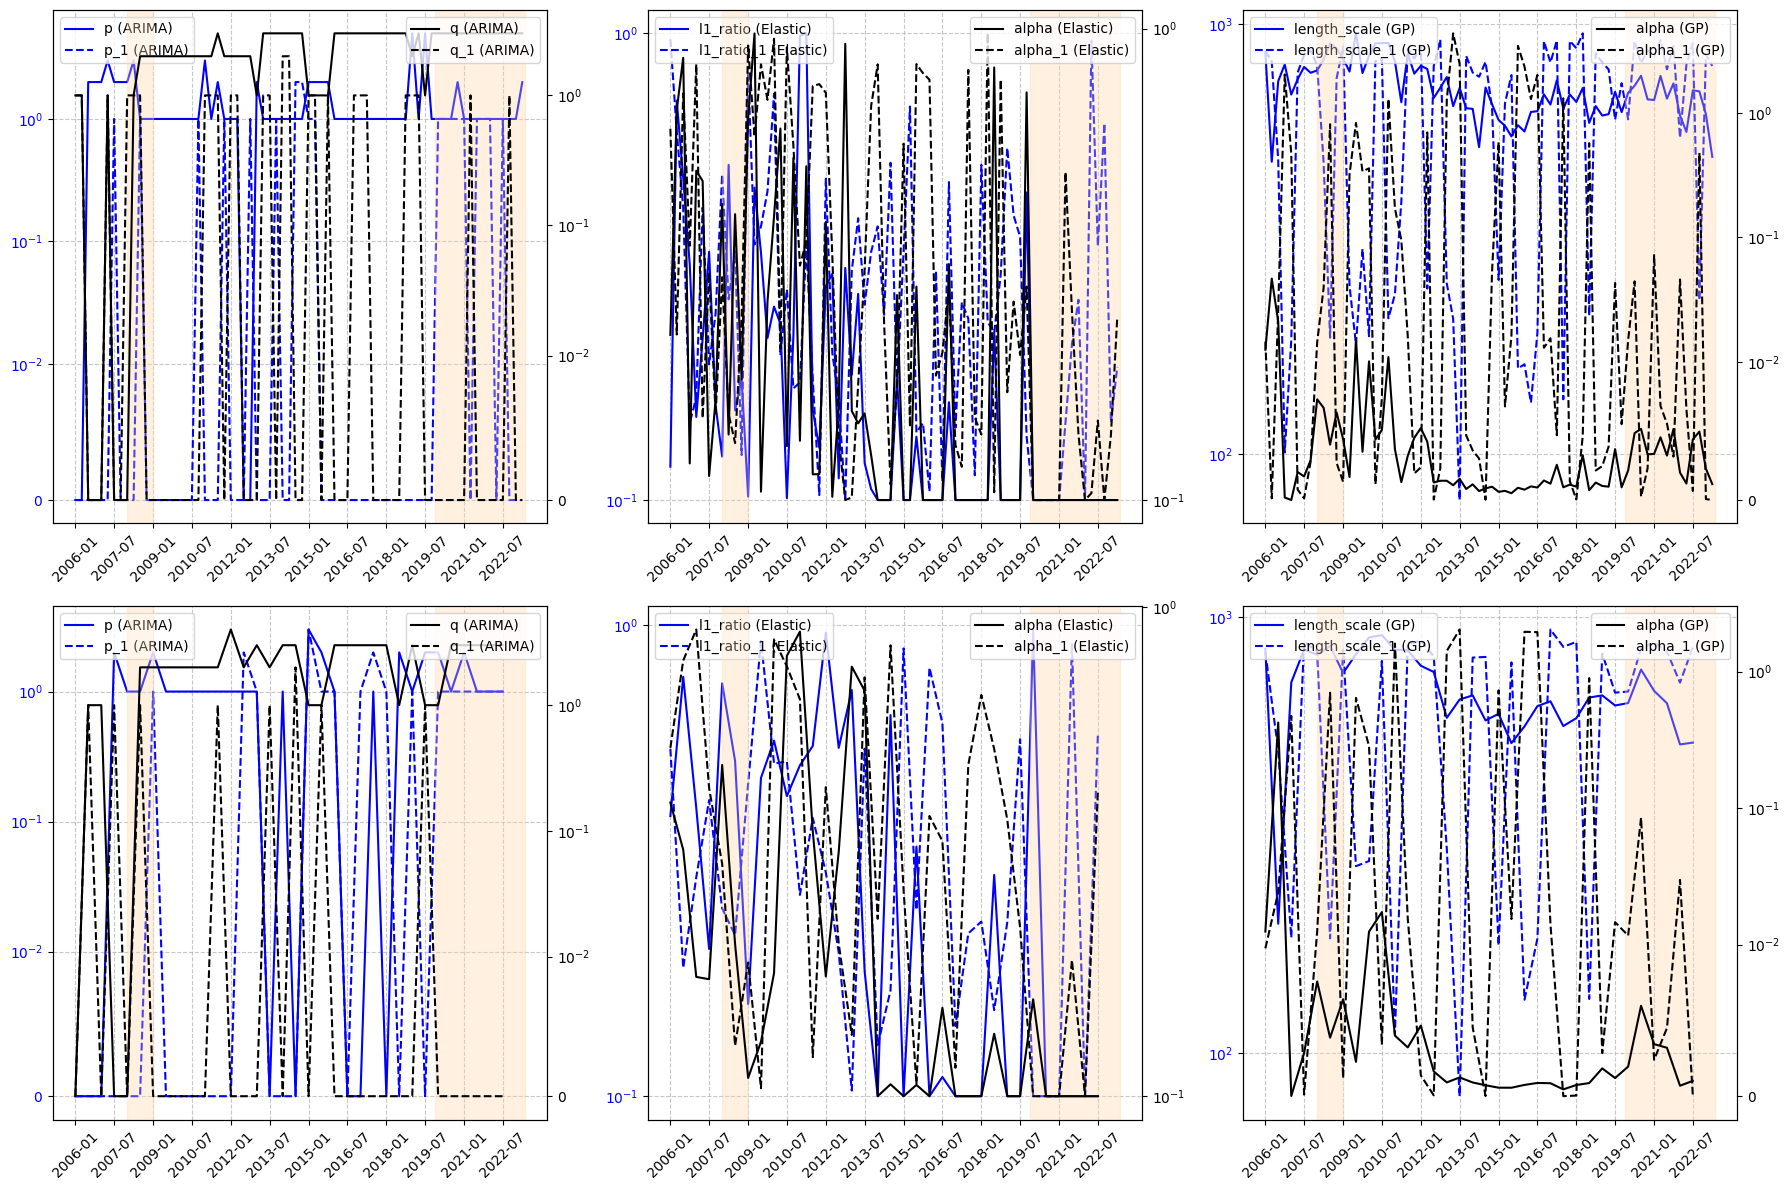

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def obtener_indices_filtrados(data, step):
    """
    Filtra los índices de un DataFrame o Series a partir del primer año,
    tomando cada 'step' datos.

    :param data: DataFrame o Series con un índice de tipo datetime
    :param step: Paso para seleccionar los datos (3 o 6, por ejemplo)
    :return: Índices filtrados
    """
    first_year = data.index[0].year
    data_after_first_year = data[data.index.year > first_year]
    selected_indices = data_after_first_year.index[::step]
    return selected_indices

def filtrar_etiquetas(selected_dates, interval):
    """
    Filtra las etiquetas para mostrar solo cada cierto número de meses.

    :param selected_dates: Lista de fechas seleccionadas
    :param interval: Intervalo de meses para filtrar las etiquetas
    :return: Fechas filtradas
    """
    return selected_dates[::interval]

def plot_dual_axis(ax1, label, y1_col, y2_col, params, yscale='linear', selected_dates=None, interval=6, highlight_periods=None):
    """
    Genera una gráfica con dos ejes y en un subplote específico.

    :param ax1: El eje principal donde se dibujará la gráfica
    :param label: El nombre del modelo (ARIMA, Elastic, GP)
    :param y1_col: Nombre de la columna para el primer eje y
    :param y2_col: Nombre de la columna para el segundo eje y
    :param params: Lista de parámetros [periodo, cantidad_incrustada, fold]
    :param yscale: Escala para los ejes y ('linear' o 'log')
    :param selected_dates: Fechas seleccionadas para etiquetar el eje X
    :param interval: Intervalo de meses para filtrar las etiquetas del eje X
    :param highlight_periods: Lista de períodos a destacar con franjas
    """
    data0 = pd.read_excel(f'{path}{params[2]}/Params/{label}_0.xlsx')
    data1 = pd.read_excel(f'{path}{params[2]}/Params/{label}_1.xlsx')
    if label=='GP':
        data0['length_scale']=np.array(data0['length_scale'].apply(lambda x: list(map(float, x.strip('[]').split()))).to_list()).mean(axis=1)

        data1['length_scale']=np.array(data1['length_scale'].apply(lambda x: list(map(float, x.strip('[]').split()))).to_list()).mean(axis=1)


    if label in ['ARIMA', 'SARIMA']:
        data0['order'] = data0['order'].astype(str)
        data0[['p', 'd', 'q']] = data0['order'].str.extract(r'\((\d+), (\d+), (\d+)\)')
        data0[['p', 'd', 'q']] = data0[['p', 'd', 'q']].astype(int)
        data0 = data0.drop(columns=['order'])

        data1['order'] = data1['order'].astype(str)
        data1[['p', 'd', 'q']] = data1['order'].str.extract(r'\((\d+), (\d+), (\d+)\)')
        data1[['p', 'd', 'q']] = data1[['p', 'd', 'q']].astype(int)
        data1 = data1.drop(columns=(['order']))
    y1 = data0[y1_col].values
    y2 = data0[y2_col].values
    y1_1 = data1[y1_col].values
    y2_1 = data1[y2_col].values
    ax1.plot(selected_dates,y1, color='blue', label=f'{y1_col} ({label})')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, linestyle='--', alpha=0.7)

    ax2 = ax1.twinx()
    ax2.plot(selected_dates,y2, color='black', label=f'{y2_col} ({label})')
    ax2.tick_params(axis='y', labelcolor='black')

    ax1.set_yscale(yscale,linthresh=0.01)
    ax2.set_yscale(yscale,linthresh=0.01)


    ax1.plot(selected_dates,y1_1, color='blue', linestyle='--', label=f'{y1_col}_1 ({label})')
    ax2.plot(selected_dates,y2_1, color='black', linestyle='--', label=f'{y2_col}_1 ({label})')


    # Ajustar las etiquetas del eje X usando las fechas seleccionadas y filtradas
    if selected_dates is not None:
        filtered_dates = filtrar_etiquetas(selected_dates, interval)
        ax1.set_xticks(filtered_dates)  # Usar fechas directamente como ticks
        ax1.set_xticklabels([date.strftime('%Y-%m') for date in filtered_dates], rotation=45)

    # Resaltar períodos específicos con franjas
    if highlight_periods is not None:
        for start, end in highlight_periods:
            ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='bisque', alpha=0.3)
            ax2.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='bisque', alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

# Función para limpiar y convertir cadenas en listas solo si son strings
def limpiar_y_convertir(cadena):
    #if isinstance(cadena, str):
    cadena = cadena.replace(',,', ' ').replace(' ', ',')
    try:
        return eval(cadena)  # Convertir la cadena a una lista
    except SyntaxError:
        return []  # Retornar una lista vacía en caso de error
    #elif isinstance(cadena, list):
    #    return cadena  # Si ya es una lista, devolverla tal cual
    #else:
    #    return []  # Manejar otros tipos como prefieras
def plot_all_models(labels, y1_cols, y2_cols, yscales, params_list, data, highlight_periods=None):
    """
    Genera una figura con múltiples filas de subplots en función de la cantidad de listas en params_list.

    :param labels: Lista de nombres de los modelos
    :param y1_cols: Lista de nombres de las columnas para el primer eje y
    :param y2_cols: Lista de nombres de las columnas para el segundo eje y
    :param yscales: Lista de escalas para los ejes y
    :param params_list: Lista de listas de parámetros para cada conjunto de gráficos
    :param data: DataFrame con el índice de tipo datetime
    :param highlight_periods: Lista de períodos a destacar con franjas
    """
    num_rows = len(params_list)
    num_cols = len(labels)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))

    for i, params in enumerate(params_list):
        step = params[1]  # Usar el paso especificado en los parámetros
        if i==0:
            selected_dates = obtener_indices_filtrados(data, step)[:-1]
        else:
            selected_dates = obtener_indices_filtrados(data,6)[:-2]
        interval = 6 if i == 0 else 3  # Usar 6 meses para la primera fila y 3 meses para la segunda
        for j, label in enumerate(labels):
            if num_rows > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]
            plot_dual_axis(ax, label, y1_cols[j], y2_cols[j], params, yscale=yscales[j], selected_dates=selected_dates, interval=interval, highlight_periods=highlight_periods)

    plt.tight_layout()
    plt.savefig('PaperDMP.pdf')
    plt.show()

# Ejemplo de uso
labels = ['ARIMA', 'Elastic', 'GP']
y1_cols = ['p', 'l1_ratio', 'length_scale']
y2_cols = ['q', 'alpha', 'alpha']
yscales = ['symlog', 'symlog', 'symlog']
params_list = [[12, 3, '3 Meses'], [12, 6, '12 Meses']]

# Definir los períodos a resaltar con franjas
highlight_periods = [('2008-01-01', '2008-12-31'), ('2019-11-25', '2023-05-05')]

# Supongamos que este es tu DataFrame con un índice de tipo datetime
# data = pd.DataFrame(...)

plot_all_models(labels, y1_cols, y2_cols, yscales, params_list, data, highlight_periods)

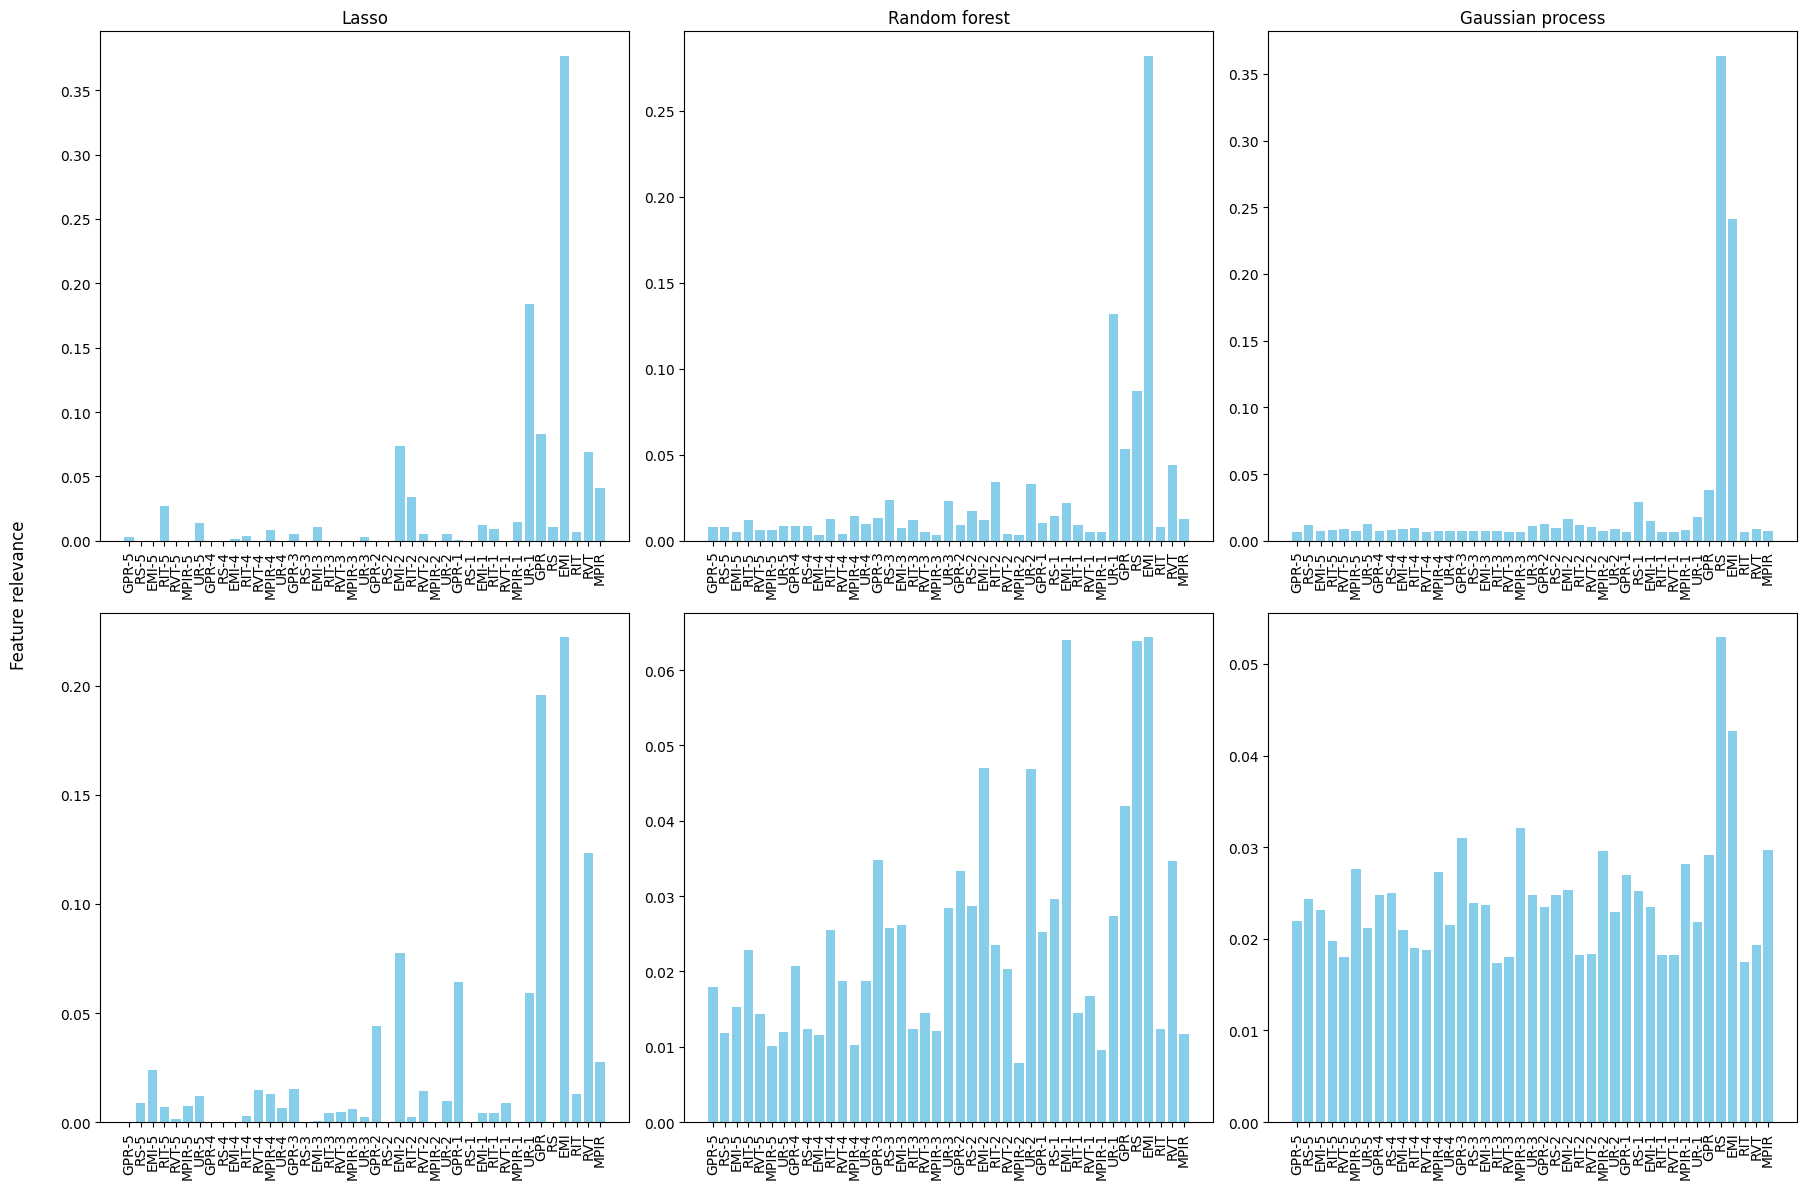

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Función para cargar y normalizar datos desde un archivo Excel
def cargar_y_normalizar(archivo, columna=None,s=0):
    df = pd.read_excel(archivo)
    if columna:
        df=pd.DataFrame(np.array(df[columna].apply(lambda x: list(map(float, x.strip('[]').split()))).to_list()))
        a=1/df.mean(axis=0)
        normalizado = abs((a/a.abs().sum()))
    elif i==0 or i==3:
        df = df.iloc[:, 1:]  # Seleccionar columnas necesarias cuando no se especifica columna
        normalizado = abs((df.mean(axis=0) / df.mean(axis=0).abs().sum()))  # Normalizar
    else:
        df = df.iloc[:, 2:]  # Seleccionar columnas necesarias cuando no se especifica columna
        normalizado = abs((df.mean(axis=0) / df.mean(axis=0).abs().sum()))  # Normalizar
    return normalizado.values

# Función para limpiar y convertir cadenas en listas solo si son strings
def limpiar_y_convertir(cadena):
    if isinstance(cadena, str):
        cadena = cadena.replace(',,', ' ').replace(' ', ',')
        try:
            return eval(cadena)  # Convertir la cadena a una lista
        except SyntaxError:
            return []  # Retornar una lista vacía en caso de error
    elif isinstance(cadena, list):
        return cadena  # Si ya es una lista, devolverla tal cual
    else:
        return []  # Manejar otros tipos como prefieras

# Función para graficar los datos normalizados en un subplot
import numpy as np
import matplotlib.pyplot as plt

def graficar_normalizado(normalizado, etiquetas, ax):
    ax.bar(np.arange(len(etiquetas)), normalizado, color='skyblue')
    # Estas etiquetas se asignan por defecto, pero luego
    # las “borramos” según la posición de la celda.
    ax.set_xlabel('Columns')
    ax.set_ylabel('Normalized Value')
    ax.set_title('Normalized Values by Column')
    ax.set_xticks(np.arange(len(etiquetas)))
    ax.set_xticklabels(etiquetas, rotation=90)

def procesar_y_graficar(archivos, etiquetas, titulo, columna=None, nrows=1, ncols=2):
    fig, axs = plt.subplots(nrows, ncols, figsize=(14, 6))
    # Si solo hay una fila o una columna, axs podría no ser
    # un array bidimensional, sino un array 1D o incluso un solo eje.
    # Para simplificar, convertimos todo a una lista plana de ejes.
    axs = np.array(axs).reshape(nrows, ncols)
    for idx, archivo in enumerate(archivos):
        # Calculamos en qué fila y columna estamos
        row = idx // ncols
        col = idx % ncols
        # Cargar y normalizar datos
        normalizado = cargar_y_normalizar(archivo, columna)
        # Graficar en el subplot correspondiente
        graficar_normalizado(normalizado, etiquetas, axs[row, col])
        # Si NO estamos en la última fila, quitamos el xlabel
        if row != nrows - 1:
            print(1)
            axs[row, col].set_xlabel('')
        # Si NO estamos en la primera columna, quitamos el ylabel
        if col != 0:
            axs[row, col].set_ylabel('')
    plt.suptitle(titulo)
    plt.tight_layout()
    plt.show()

import re
import pandas as pd
def renombrar(col):
    """
    Si la columna col es del tipo Prefijo(-sufijo),
    donde Prefijo está en [GPR, RS, EMI, RIT, RVT, MPIR, UR]
    y sufijo es opcionalmente un dígito (1..5),
    la renombramos siguiendo el mapeo:
       ""   ->  "5"
       "1"  ->  "4"
       "2"  ->  "3"
       "3"  ->  "2"
       "4"  ->  "1"
       "5"  ->  ""
    De lo contrario, devolvemos la misma columna (ej. Year, Month).
    """
    pattern = r'^(GPR|RS|EMI|RIT|RVT|MPIR|UR)(?:-(\d))?$'
    m = re.match(pattern, col)
    if m:
        prefijo = m.group(1)              # p.e. "GPR", "RS", etc.
        sufijo_original = m.group(2) or ""  # p.e. "1", "2", ..., ó "" si no había

        # Tabla de mapeo
        mapa_sufijos = {
            "":  "5",
            "1": "4",
            "2": "3",
            "3": "2",
            "4": "1",
            "5": ""
        }

        sufijo_nuevo = mapa_sufijos[sufijo_original]

        if sufijo_nuevo == "":
            return prefijo       # p.e. "GPR" si quedó sin sufijo
        else:
            return f"{prefijo}-{sufijo_nuevo}"
    else:
        return col

# --- Aplicamos el renombrado ---
Xdata= Xdata.rename(columns=renombrar)
# Definir las etiquetas
try:
    b = Xdata.drop(['UR', 'Year', 'Month'], axis=1).columns
except:
    b = Xdata

# Archivos y configuraciones de 12 meses y 3 meses
archivos_12_meses = [

    (f'{path}12 Meses/Params/Lasso_0.xlsx', None),
    (f'{path}12 Meses/Params/RF_0.xlsx', None),
    (f'{path}12 Meses/Params/GP_0.xlsx', 'length_scale'),

    (f'{path}12 Meses/Params/Lasso_1.xlsx', None),
    (f'{path}12 Meses/Params/RF_1.xlsx', None),
    (f'{path}12 Meses/Params/GP_1.xlsx', 'length_scale')
]

archivos_3_meses = [

    (f'{path}3 Meses/Params/Lasso_0.xlsx', None),
    (f'{path}3 Meses/Params/RF_0.xlsx', None),
    (f'{path}3 Meses/Params/GP_0.xlsx', 'length_scale'),
    (f'{path}3 Meses/Params/Lasso_1.xlsx', None),
    (f'{path}3 Meses/Params/RF_1.xlsx', None),
    (f'{path}3 Meses/Params/GP_1.xlsx', 'length_scale'),
]
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
names=['Lasso','Random forest', 'Gaussian process']
for i, (archivo, columna) in enumerate(archivos_3_meses):
    # Calcula la posición en la grilla
    row = i // 3
    col = i % 3
    # Carga y normaliza
    normalizado = cargar_y_normalizar(archivo, columna, s=i)
    # Dibuja en el subplot [row, col]
    graficar_normalizado(normalizado, b, axs[row, col])
    # Quitar el X-label si NO estamos en la última fila
    if row != 0:  # 1 es la última fila (con nrows=2)
        axs[row, col].set_title('')
    else:
        axs[row, col].set_title(names[i])
    axs[row, col].set_xlabel('')
    # Quitar el Y-label si NO estamos en la primera columna
    #if col != 0:
    axs[row, col].set_ylabel('')
fig.supylabel('Feature relevance', x=-0.001, fontsize=12)

plt.tight_layout()
plt.savefig('Inter3M.pdf')
plt.show()




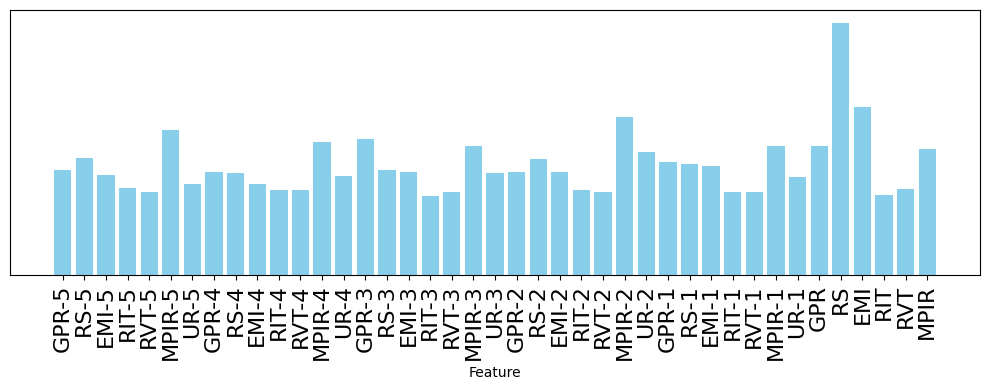

In [11]:
axs=plt.figure(figsize=(10, 4))
archivo, columna =  (f'{path}12 Meses/Params/GP_1.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
plt.bar(np.arange(len(b)), normalizado, color='skyblue')
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
plt.yticks([])
plt.xlabel('Feature')
plt.xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=16)
plt.tight_layout()
plt.show()
#plt.xticklabels(columna, rotation=90)

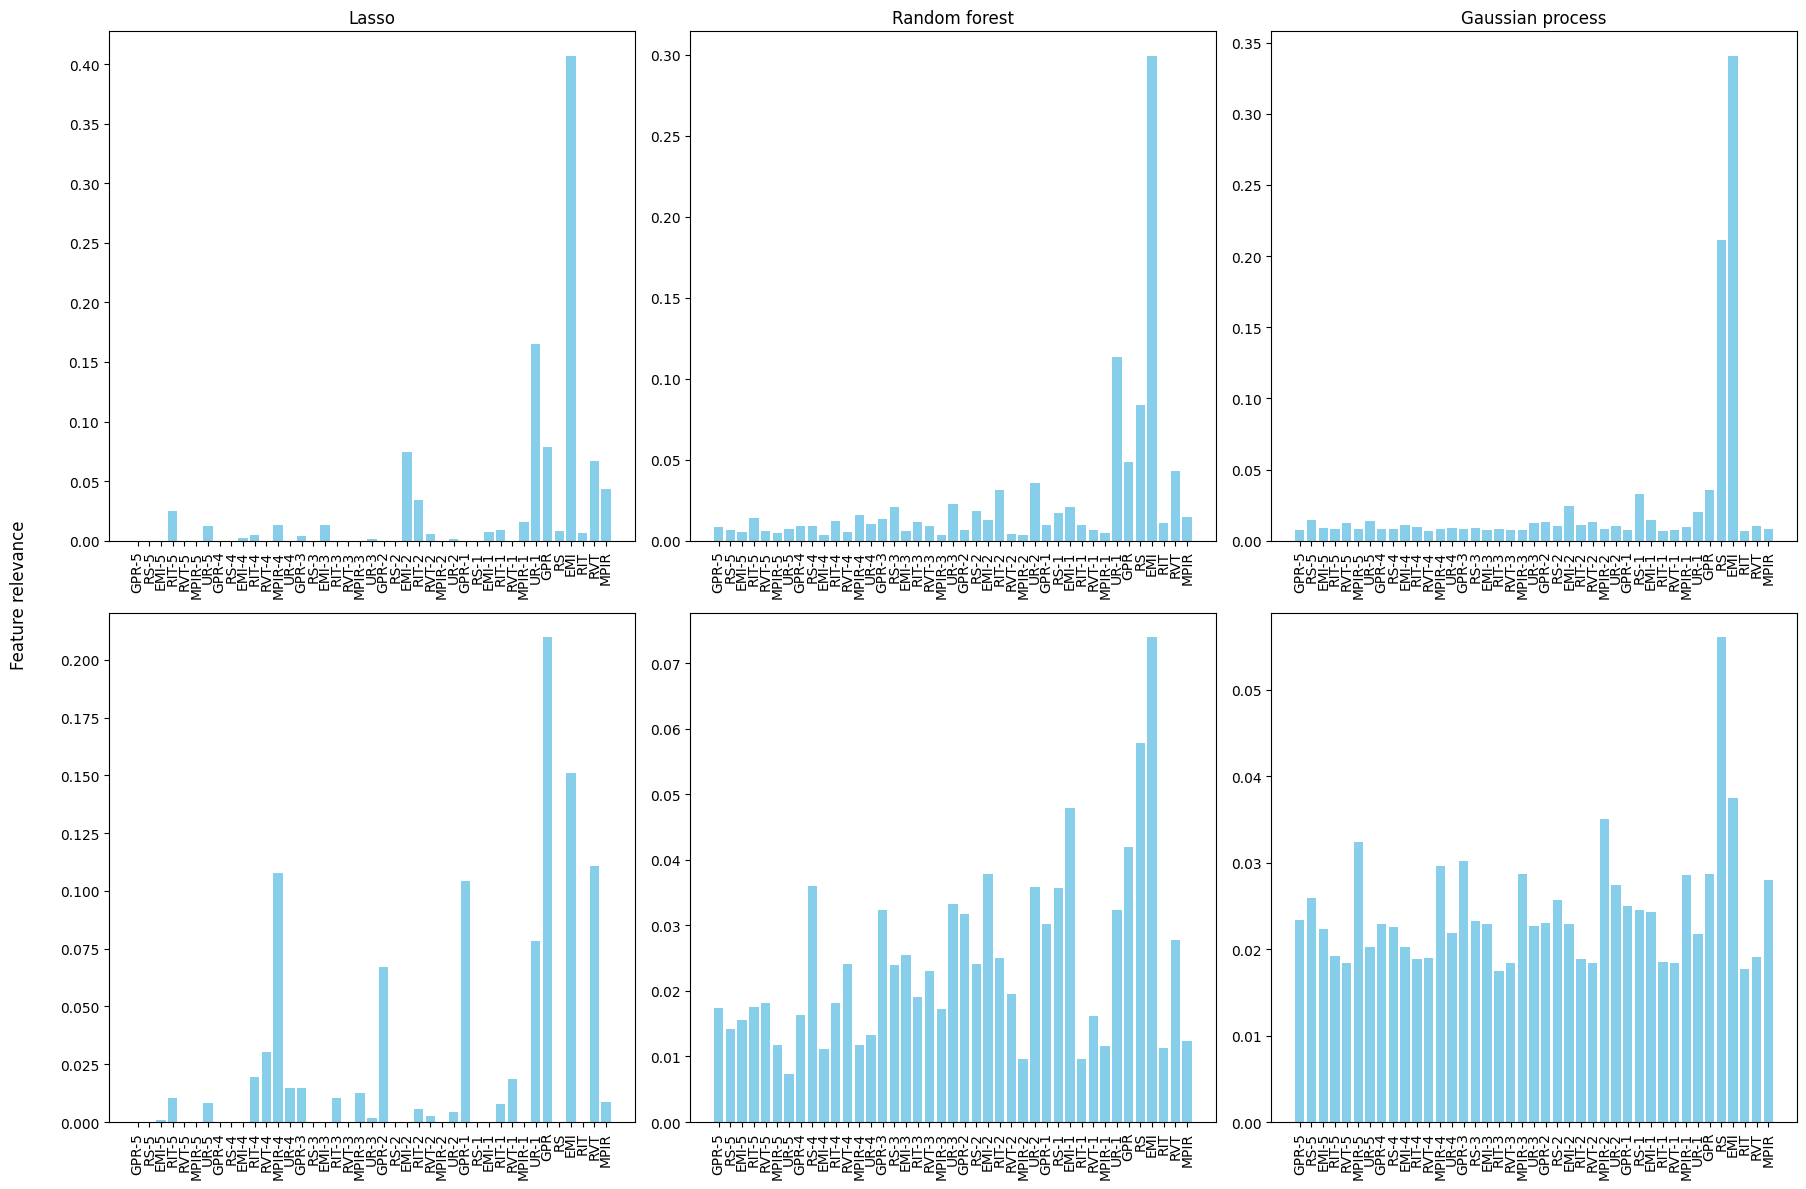

In [12]:
# Graficar los datos de 12 meses en una figura
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, (archivo, columna) in enumerate(archivos_12_meses):
    # Calcula la posición en la grilla
    row = i // 3
    col = i % 3
    # Carga y normaliza
    normalizado = cargar_y_normalizar(archivo, columna, s=i)
    # Dibuja en el subplot [row, col]
    graficar_normalizado(normalizado, b, axs[row, col])
    # Quitar el X-label si NO estamos en la última fila
    if row != 0:  # 1 es la última fila (con nrows=2)
        axs[row, col].set_title('')
    else:
        axs[row, col].set_title(names[i])
    axs[row, col].set_xlabel('')
    # Quitar el Y-label si NO estamos en la primera columna
    #if col != 0:
    axs[row, col].set_ylabel('')
fig.supylabel('Feature relevance', x=-0.001, fontsize=12)

plt.tight_layout()
plt.savefig('Inter6M.pdf')
plt.show()
